In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
applicationData = pd.read_csv('application_data.csv')

In [3]:
previousApplication = pd.read_csv('previous_application.csv')

In [4]:
print(applicationData.size)

37516342


In [5]:
print(applicationData.shape)

(307511, 122)


### Analysing Data Types

In [6]:
applicationData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                   

In [7]:
objectTypeColumns = list(applicationData.select_dtypes(['object']).columns)
print(len(objectTypeColumns))

16


#### 16 columns have dypes as object. Lets observe the kind of data

In [8]:
for column in objectTypeColumns:
    print(column)
    print(applicationData[column].value_counts())
    print('*'*100)

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
****************************************************************************************************
CODE_GENDER
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
****************************************************************************************************
FLAG_OWN_CAR
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
****************************************************************************************************
FLAG_OWN_REALTY
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
****************************************************************************************************
NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
********************

Following columns contain string/ text data
- NAME_CONTRACT_TYPE
- NAME_TYPE_SUITE
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- OCCUPATION_TYPE
- ORGANIZATION_TYPE
- FONDKAPREMONT_MODE
- HOUSETYPE_MODE
- WALLSMATERIAL_MODE

Following can be considered for converting to int and map to 0 and 1 for analysis
- CODE_GENDER 
- FLAG_OWN_CAR
- FLAG_OWN_REALTY
- WEEKDAY_APPR_PROCESS_START
- EMERGENCYSTATE_MODE

## Handling Null values

In [9]:
def getColumnWiseNulls():
    colWiseNulls = round(100*(applicationData.isnull().sum()/len(applicationData.index)), 2)
    colWiseNulls= colWiseNulls.iloc[colWiseNulls.nonzero()].sort_values(ascending=False)
    return colWiseNulls

In [10]:
def plotColumnWiseNulls(percentage=0):
    res = getColumnWiseNulls()
    plt.figure(figsize=(20,4))
    res[res>percentage].plot.bar()
    

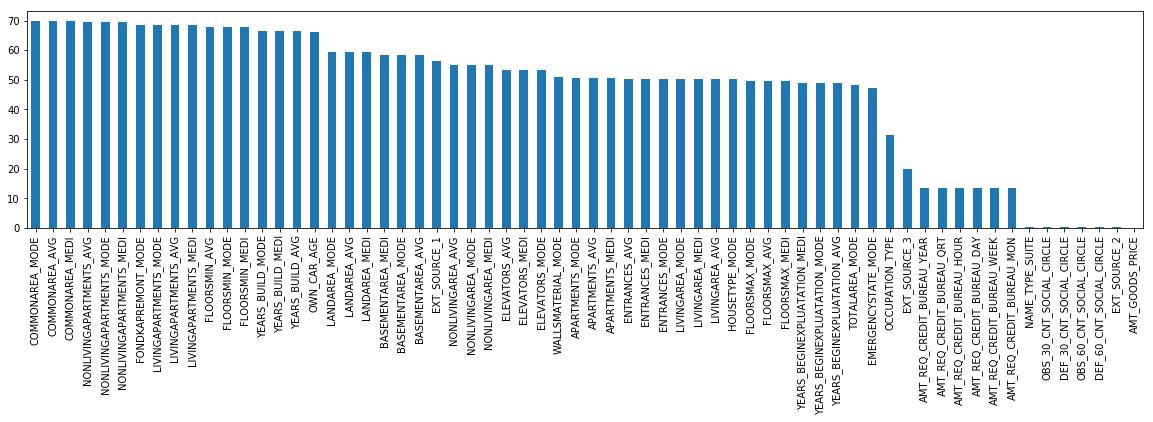

In [11]:
plotColumnWiseNulls(0)

In [12]:
### only four values are null in gender column. We can impute it with mode
applicationData['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [13]:
mode=applicationData['CODE_GENDER'].mode().values[0]

In [14]:
applicationData['CODE_GENDER'].replace('XNA', mode, inplace=True)

In [15]:
applicationData['CODE_GENDER'].value_counts()

F    202452
M    105059
Name: CODE_GENDER, dtype: int64

## Drop columns with more that 50 % null values

In [16]:
def RemoveNullColumns(dataFrame, percent= 0.5):
    df = dataFrame.copy()
    ishape = df.shape
    colWiseNulls = df.isnull().sum()/len(df.index)
    colNames = list(colWiseNulls[colWiseNulls.values>=percent].index)
    df.drop(labels=colNames, inplace=True , axis=1)
    
    return df

In [17]:
applicationData = RemoveNullColumns(applicationData)

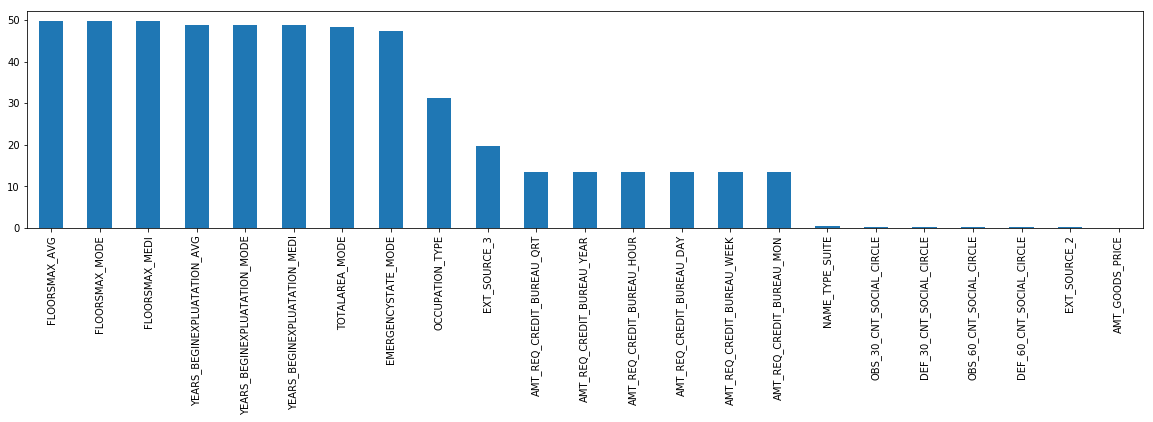

In [18]:
plotColumnWiseNulls()

In [19]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_HOUR'].describe())
applicationData['AMT_REQ_CREDIT_BUREAU_HOUR'].value_counts()

count    265992.000000
mean          0.006402
std           0.083849
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64


0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

#### Since both median and mode are 0, it is safe to fill nulls with 0. Mean cannot work out here since the number of enquiries cannot be fractional


In [20]:
applicationData.loc[applicationData['AMT_REQ_CREDIT_BUREAU_HOUR'].isnull(),'AMT_REQ_CREDIT_BUREAU_HOUR']=0

In [21]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_HOUR'].describe())
applicationData['AMT_REQ_CREDIT_BUREAU_HOUR'].value_counts()

count    307511.000000
mean          0.005538
std           0.078014
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64


0.0    305885
1.0      1560
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

In [22]:
import math
def fillNaForCreditInquries(row,currentColumn, previousColumn, altValue):
    if math.isnan(row[currentColumn]):
        res = max(row[previousColumn], altValue)
    else:
        res=  row[currentColumn]
    return res

#### AMT_REQ_CREDIT_BUREAU_DAY


In [23]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_DAY'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_DAY'].isnull().sum())
print(applicationData['AMT_REQ_CREDIT_BUREAU_DAY'].unique())
applicationData['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts()


count    265992.000000
mean          0.007000
std           0.110757
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64
41519
[ 0. nan  1.  3.  2.  4.  5.  6.  9.  8.]


0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

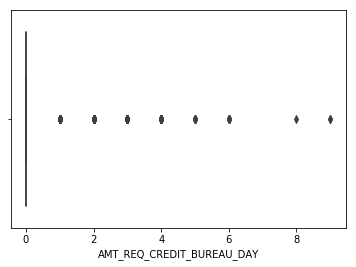

In [24]:
sns.boxplot(x='AMT_REQ_CREDIT_BUREAU_DAY', data=applicationData)

In [25]:
# For imputation we use hourly data. If hourly review is available and greater than 0 we use that else we impute with median/mode(both are 0)

applicationData['AMT_REQ_CREDIT_BUREAU_DAY'] = applicationData.apply(fillNaForCreditInquries, axis=1, args=('AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 0))
print(applicationData['AMT_REQ_CREDIT_BUREAU_DAY'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts()

0


0.0    306022
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

#### AMT_REQ_CREDIT_BUREAU_WEEK


In [26]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'].value_counts()


count    265992.000000
mean          0.034362
std           0.204685
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64
41519


0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64

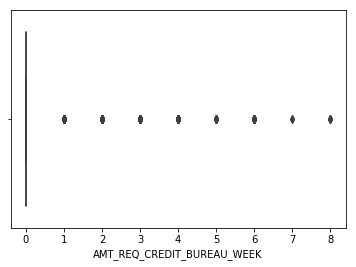

In [27]:
sns.boxplot(x='AMT_REQ_CREDIT_BUREAU_WEEK', data=applicationData)

In [28]:
# applicationData.loc[applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'].isnull(),'AMT_REQ_CREDIT_BUREAU_WEEK']=0
applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'] = applicationData.apply(fillNaForCreditInquries, axis=1, args=('AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_DAY', 0))

In [29]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_WEEK'].value_counts()


count    307511.000000
mean          0.029723
std           0.190728
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64
0


0.0    298975
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64

#### AMT_REQ_CREDIT_BUREAU_MON


In [30]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_MON'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_MON'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_MON'].value_counts()


count    265992.000000
mean          0.267395
std           0.916002
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          27.000000
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64
41519


0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
27.0         1
22.0         1
23.0         1
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: int64

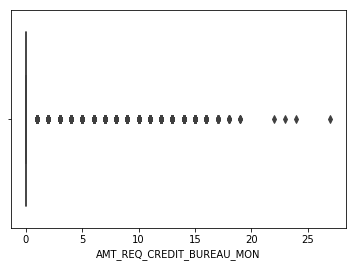

In [31]:
sns.boxplot(x='AMT_REQ_CREDIT_BUREAU_MON', data=applicationData)

#### There are more outliers in monthly inquiries. We will handle these later

In [32]:
# applicationData.loc[applicationData['AMT_REQ_CREDIT_BUREAU_MON'].isnull(),'AMT_REQ_CREDIT_BUREAU_MON']=0
applicationData['AMT_REQ_CREDIT_BUREAU_MON'] = applicationData.apply(fillNaForCreditInquries, axis=1, args=('AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_WEEK', 0))

In [33]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_MON'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_MON'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_MON'].value_counts()


count    307511.000000
mean          0.231293
std           0.856810
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          27.000000
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64
0


0.0     263752
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
27.0         1
22.0         1
23.0         1
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: int64

#### AMT_REQ_CREDIT_BUREAU_QRT


In [34]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_QRT'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_QRT'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_QRT'].value_counts()


count    265992.000000
mean          0.265474
std           0.794056
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         261.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64
41519


0.0      215417
1.0       33862
2.0       14412
3.0        1717
4.0         476
5.0          64
6.0          28
7.0           7
8.0           7
19.0          1
261.0         1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64

####  Values of 19, 261 is a clear outlier. Also there is only 1 record each with such values hence we can consider deleting or capping it later

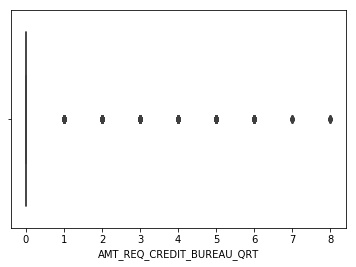

In [35]:
sns.boxplot(x='AMT_REQ_CREDIT_BUREAU_QRT', data=applicationData[applicationData['AMT_REQ_CREDIT_BUREAU_QRT']<19])

In [36]:
# applicationData.loc[applicationData['AMT_REQ_CREDIT_BUREAU_QRT'].isnull(),'AMT_REQ_CREDIT_BUREAU_QRT']=0
applicationData['AMT_REQ_CREDIT_BUREAU_QRT'] = applicationData.apply(fillNaForCreditInquries, axis=1, args=('AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_MON', 0))

In [37]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_QRT'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_QRT'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_QRT'].value_counts()


count    307511.000000
mean          0.229631
std           0.744059
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         261.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64
0


0.0      256936
1.0       33862
2.0       14412
3.0        1717
4.0         476
5.0          64
6.0          28
7.0           7
8.0           7
19.0          1
261.0         1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64

#### AMT_REQ_CREDIT_BUREAU_YEAR


In [38]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_YEAR'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()


count    265992.000000
mean          1.899974
std           1.869295
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          25.000000
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64
41519


0.0     71801
1.0     63405
2.0     50192
3.0     33628
4.0     20714
5.0     12052
6.0      6967
7.0      3869
8.0      2127
9.0      1096
11.0       31
12.0       30
10.0       22
13.0       19
14.0       10
17.0        7
15.0        6
19.0        4
18.0        4
16.0        3
21.0        1
23.0        1
25.0        1
20.0        1
22.0        1
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

####  Values >15 have significantly lower number of values. and may be treated as outliers

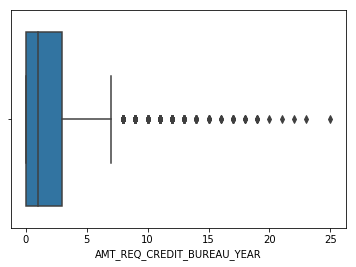

In [39]:
sns.boxplot(x='AMT_REQ_CREDIT_BUREAU_YEAR', data=applicationData)

In [40]:
temp = applicationData.loc[applicationData['AMT_REQ_CREDIT_BUREAU_YEAR']<10, 'AMT_REQ_CREDIT_BUREAU_YEAR']
temp.describe()

count    265851.000000
mean          1.894121
std           1.851201
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max           9.000000
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

In [41]:
#### If we remove the outliers i.e applications with >= 10 inquiries , mean and median, mode still tend to 1. So we can substitute the value by 1

In [42]:
applicationData['AMT_REQ_CREDIT_BUREAU_YEAR'] = applicationData.apply(fillNaForCreditInquries, axis=1, args=('AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_QRT', 1))

In [43]:
print(applicationData['AMT_REQ_CREDIT_BUREAU_YEAR'].describe())
print(applicationData['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull().sum())
applicationData['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()


count    307511.000000
mean          1.778463
std           1.765523
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          25.000000
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64
0


1.0     104924
0.0      71801
2.0      50192
3.0      33628
4.0      20714
5.0      12052
6.0       6967
7.0       3869
8.0       2127
9.0       1096
11.0        31
12.0        30
10.0        22
13.0        19
14.0        10
17.0         7
15.0         6
19.0         4
18.0         4
16.0         3
21.0         1
23.0         1
25.0         1
20.0         1
22.0         1
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

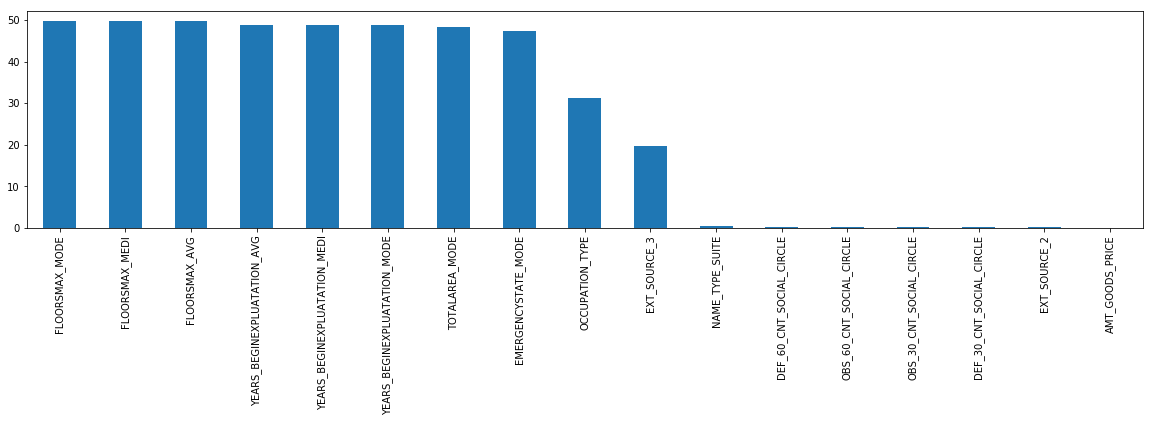

In [44]:
# inspect null values
plotColumnWiseNulls()